# Using Regression with CAPM

This code is for making a simple CAPM Regression Model using Dr. French's Historical Data and the TD Ameritrade API's Candle Data

It takes data from: 
- ~~TD Ameritrade and tda-api: https://developer.tdameritrade.com/ & https://tda-api.readthedocs.io/en/latest/~~ (Doesn't give Adj. Close Data)
- Yahoo Finance: https://finance.yahoo.com/ and the yfinance Package: https://readthedocs.org/projects/yfinance/
- Dr. Kenneth R. French's Data Library(for risk-free rates and market rates): https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

#### For Next Time: You can directly connect to Dr. French's Database using the pandas datareader!

##### data = reader.DataReader(<filename>, 'famafrench', start, end)

This notebook also utilizes some prewritten functions to pull data without the big setups required for the tda-api, and can be found in the configs.py file in the functions subfolder

The Configs and CSV Data Files will be saved in the repository /Users/dB/.secret/ under the filename 'tda-api-v6.json' and pathname 'ff-research-data'. Their paths are listed here for easier access while I write in this notebook:

/Users/dB/.secret/tda-api-v6.json

/Users/dB/.secret/ff-research-data/

## Step 1: Import Necessary Packages and Add Configs

In [43]:
# Imports -----------------------------------------------------------------------------
import functions_for_notebooks.configs as c
# from tda.client import Client
# from tda import auth as a
import yfinance as yf
import pandas as pd
import datetime as dt
import statsmodels.api as sm

In [24]:
# Configs -----------------------------------------------------------------------------
# tda_api_json_path = '/Users/dB/.secret/tda-api-v6.json'
# tda_api_json = c.get_account_data(tda_api_json_path)

ff_data_path = '/Users/dB/.secret/ff-research-data/F-F_Research_Data_Factors.CSV'
ff_data_weekly_path = '/Users/dB/.secret/ff-research-data/F-F_Research_Data_Factors_weekly.CSV'
ff_data_daily_path = '/Users/dB/.secret/ff-research-data/F-F_Research_Data_Factors_daily.csv'

symbol = 'AMD'
end_dt = dt.datetime.now() # Today's Date
start_dt = end_dt - dt.timedelta(days = 1825) # Subtract 5 Years from Today

## Step 2: Collect Data and Process into DataFrames

To collect the data, we need to read Dr. French's CSVs for data and call the ~~TD Ameritrade~~ Yahoo Finance API for candle data.

Reading Dr. French's CSVs is a simple process, all we need to do is decide to use daily or weekly data and then call Panda's read_from_csv() function. We will need to translate the dates into datetime objects to match up with the API data, which we can quickly do with pandas.to_datetime(index, format=%Y%m%d)

Calling yfinance.download() will pull down candle data for a stock. This will provide us with the open, close, adjusted close, high, low and volume data for the specified timeframe. To get a larger dataset that we can join with Dr. French's dataset with pandas.concat(), we need to call download() with an interval of 1 day('1d')

~~I have a function from the dBI project named get_price_history_df() that can call the API once a Client object is created, and we can pass in '1d' and '1w' as the periods parameter for the daily and weekly data.~~

In [21]:
# Function to read data from the CSV
def read_ff_csvs(path: str):
    try:
        df = pd.read_csv(path, skiprows=3, index_col=0) # Read CSV, skip the intro text in the csv
        df.drop(index=df.index[-1], axis=0, inplace=True) # drop the "Copyright" row at the bottom
        df.index = pd.to_datetime(df.index, format='%Y%m%d') # Format the date column(index) into a datetime object
        
    except FileNotFoundError as e:
        print(e)
    
    return df

daily_data = read_ff_csvs(ff_data_daily_path)

daily_data.index.name = 'datetime'

# Print the Data
print('Daily Data:')
print(daily_data.head())

Daily Data:
            Mkt-RF   SMB   HML     RF
datetime                             
1926-07-01    0.10 -0.25 -0.27  0.009
1926-07-02    0.45 -0.33 -0.06  0.009
1926-07-06    0.17  0.30 -0.39  0.009
1926-07-07    0.09 -0.58  0.02  0.009
1926-07-08    0.21 -0.38  0.19  0.009


In [25]:
# Call the API for candle data
candles_daily = yf.download(tickers=symbol, start=start_dt, end=end_dt, interval='1d')

# Printing Candles DataFrames:
print('Daily Candles: ')
print(candles_daily.head())

[*********************100%%**********************]  1 of 1 completed

Daily Candles: 
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2019-01-16  20.400000  20.540001  19.709999  19.730000  19.730000  70849300
2019-01-17  19.490000  20.510000  19.020000  20.250000  20.250000  85018400
2019-01-18  20.370001  21.049999  20.020000  20.770000  20.770000  88131000
2019-01-22  20.480000  20.920000  19.700001  19.760000  19.760000  78513700
2019-01-23  20.030001  20.480000  19.549999  19.799999  19.799999  77811300


# Step 3: Merge the DataFrames

This step involves performing an inner-join on the API Data and French's Data DataFrames using DataFrame.concat

In [27]:
# Concatenate the DataFrames
daily_df = pd.concat([candles_daily, daily_data], axis=1)
daily_df = daily_df.dropna()

# Print the DataFrames
print('Daily DataFrame:')
print(daily_df)

Daily DataFrame:
                  Open        High         Low       Close   Adj Close  \
2019-01-16   20.400000   20.540001   19.709999   19.730000   19.730000   
2019-01-17   19.490000   20.510000   19.020000   20.250000   20.250000   
2019-01-18   20.370001   21.049999   20.020000   20.770000   20.770000   
2019-01-22   20.480000   20.920000   19.700001   19.760000   19.760000   
2019-01-23   20.030001   20.480000   19.549999   19.799999   19.799999   
...                ...         ...         ...         ...         ...   
2023-11-24  122.029999  123.250000  121.540001  122.309998  122.309998   
2023-11-27  122.070000  123.889999  121.769997  122.650002  122.650002   
2023-11-28  121.980003  122.540001  120.790001  122.010002  122.010002   
2023-11-29  123.980003  125.730003  123.480003  123.849998  123.849998   
2023-11-30  123.610001  124.050003  119.650002  121.160004  121.160004   

                Volume  Mkt-RF   SMB   HML     RF  
2019-01-16  70849300.0    0.28  0.04  0.92

Let's get rid of all the columns we don't need to keep the outputs cleaner

In [28]:
ddf_ff_capm = daily_df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'SMB','HML'], axis=1) # ddf_f = Daily DataFrame Filtered For CAPM
print(ddf_ff_capm.head())

            Adj Close  Mkt-RF    RF
2019-01-16  19.730000    0.28  0.01
2019-01-17  20.250000    0.75  0.01
2019-01-18  20.770000    1.29  0.01
2019-01-22  19.760000   -1.53  0.01
2019-01-23  19.799999    0.15  0.01


# Step 4: Format DataFrame for Regression

## CAPM Formula: Ri - rf = α + β * (Mkt - rf) + ε

- Ri : Market Return
- rf : Risk-Free Rate
- Mkt : Market Rate
- α : Alpha
- β : Asset-Specific Risk
- ε : Random Noise

French's Dataset provides us with the (Mkt - rf) and rf terms, so we just need to calculate Ri before using regression. 

## Calculating Daily Returns:

In [47]:
df = ddf_ff_capm
df['Ri'] = df['Adj Close'].resample('1D').ffill().pct_change() # Calculates the Daily Percent Change from the Adjusted Close Price
df['Ri'] = df['Ri']*100
df2 = df.dropna()
print(df2.head())
capm_df = df2

            Adj Close  Mkt-RF    RF        Ri
2019-01-17  20.250000    0.75  0.01  2.635583
2019-01-18  20.770000    1.29  0.01  2.567903
2019-01-22  19.760000   -1.53  0.01 -4.862784
2019-01-23  19.799999    0.15  0.01  0.202424
2019-01-24  20.850000    0.23  0.01  5.303036


## Define the Variables:

In [48]:
iv = capm_df['Mkt-RF'] # iv = independent variable
dv = capm_df['Ri']-capm_df['RF'] # dv = dependent variable

## Using Statsmodel.API to build the regression Model

Later I will be building different Models from scratch to better understand what is going on underneath the hood, but to finish this notebook I will be performing CAPM Regression using the same methods as Algovibes in his video on CAPM Regression in Python(https://www.youtube.com/watch?v=Y-BqM3WaX-I)

The Model we will be using is the Ordinary Least Squares Model

In [49]:
# Adding an Intercept:
ic = sm.add_constant(iv)

# Build the Model:
model = sm.OLS(dv, ic)

# Fit the Model
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     884.9
Date:                Mon, 15 Jan 2024   Prob (F-statistic):          8.33e-147
Time:                        12:30:03   Log-Likelihood:                -2896.3
No. Observations:                1227   AIC:                             5797.
Df Residuals:                    1225   BIC:                             5807.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1158      0.073      1.580      0.114      -0.028       0.260
Mkt-RF         1.5740      0.053     29.747      0.000       1.470       1.678
==============================================================================
Omnibus:                      323.312   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1801.290
Skew:                           1.101   Prob(JB):                         0.00
Kurtosis:                       8.512   Cond. No.                         1.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This gives us the Values of α and β, which can be found in the 2nd table of the summary, under the 'coef' column. The value of α is the 'const' row, and the value of β is in the 'Mkt-RF' row.

But how do we know if the values are correct?
We can check the Yahoo Finance Page for the Stock(AMD) and compare the Betas.(https://finance.yahoo.com/quote/AMD/)

Lastly, we can plot the data with Seaborn like Algovibes did in his tutorial:

<Axes: xlabel='Mkt-RF', ylabel='Ri'>

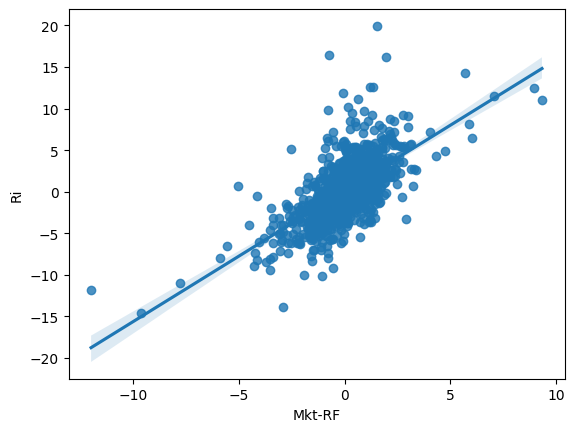

In [52]:
import seaborn as sns
sns.regplot(x='Mkt-RF', y='Ri', data=capm_df)

## Next Steps: From Dr. Forjan's Lecture

- Graph...
    - Security Market Line(SML): X-Axis is Beta, Y-Axis is Expected Return(E(Ri))
        - Mark RF, E(Rm), and Beta of 1.0
        - Draw Box with vertices (0,RF), (0,E(Rm)), (1,0), (1, Beta(i)=Beta(mkt))
    - 
- Interpreting Beta...

    - For a company i...

        - βi = 𝜎im/𝜎m^2
            
            Where:
            - 𝜎m is the variance of the market return
            - 𝜎im is the covariance of the individual stock's return and the market return
        - βi = (ρim) * (𝜎im/𝜎m^2) 
            
            Where:
            - ρim is the correlation coefficient between the individual stock's return and the market return